## Zadanie domowe: Projektowanie filtru metodą okien


In [1]:
import cv2
import os
import requests
from matplotlib import pyplot as plt
import numpy as np

url = "https://raw.githubusercontent.com/vision-agh/poc_sw/master/08_Fourier/"

LENA_FILENAME = "lena.bmp"
for fileName in [LENA_FILENAME]:
    if not os.path.exists(fileName):
        r = requests.get(url + fileName, allow_redirects=True)
        open(fileName, "wb").write(r.content)

lena_image = cv2.imread(LENA_FILENAME, flags=cv2.IMREAD_GRAYSCALE)

In [2]:
def show_grayscale_image(ax, image, title=None, full_scale: bool = False):
    vmin, vmax = (0, 256) if full_scale else (None, None)
    ax.axis("off")
    ax.imshow(image, cmap="gray", vmin=vmin, vmax=vmax)
    if ax == plt:
        plt.title(title)
    else:
        ax.set_title(title)

Zauważone w zadaniu z filtracją artefakty są efektem zastosowania filtru idealnego (wycięcia odpowiednich częstotliwości).
Aby je usunąć, należy filtr idealny w dziedzinie przestrzennej przemnożyć przez dwuwymiarowe okno (stworzone na podstawie jednowymiarowego).

1.  Zdefiniuj rozmiar filtra (np. 21).

2.  Stwórz okno np. Hamminga (`np.Hmming`) o zadanym rozmiarze.

3.  Na podstawie tego okna stwórz okno dwuwymiarowe: $F = f^Tf$.
    Można to zrealizować prostą instrukcją:
    hanning2d = np.outer(hanning, hanning)


In [3]:
FILTER_SIZE = 21

window = np.hamming(FILTER_SIZE)

hanning_filter = np.outer(window, window)

4.  Stwórz wzorcowy filtr idealny tak samo jak w poprzednim ćwiczeniu.
    Jego rozmiar musi być taki sam jak zdefiniowany w punkcie pierwszym.


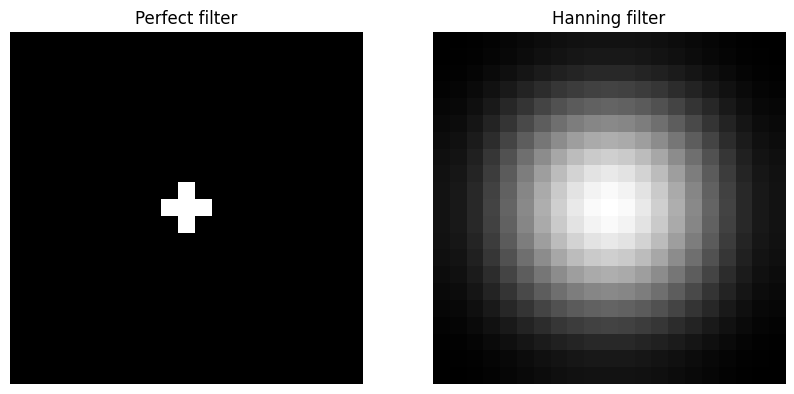

In [4]:
def create_perfect_filter(size, predicate=lambda freq: freq <= 0.1):
    FSpaceRows = 2 * np.fft.fftshift(np.fft.fftfreq(size))
    FSpaceRowsM = np.outer(FSpaceRows, np.ones([1, size]))

    FSpaceCols = 2 * np.fft.fftshift(np.fft.fftfreq(size))
    FSpaceColsM = np.outer(np.ones([1, size]), FSpaceCols)

    FreqR = np.sqrt(np.square(FSpaceRowsM) + np.square(FSpaceColsM))
    FilterF = predicate(FreqR)

    return FilterF


perfect_filter = create_perfect_filter(size=FILTER_SIZE)

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 5))
show_grayscale_image(ax1, perfect_filter, title="Perfect filter")
show_grayscale_image(ax2, hanning_filter, title="Hanning filter")

5.  Generalna zasada jest taka, że należy obliczyć odwrotną transformatę Fouriera filtru idealnego.
    Aby zagwarantować jednak dobrą lokalizację i symetryczność tworzonego filtru wykorzystuje się dodatkowe rotacje i przesunięcia.
    ```
    FilterFRot = np.rot90(np.fft.fftshift(np.rot90(FilterF, 2)), 2)
    FilterFRot3 = np.dstack((FilterFRot, np.zeros(FilterFRot.shape)))
    FilterFidft = cv2.idft(np.float32(FilterFRot3),
                    flags=cv2.DFT_SCALE | cv2.DFT_COMPLEX_OUTPUT)
    FilterFI = np.rot90(np.fft.fftshift(FilterFidft[:, :, 0]), 2)
    ```


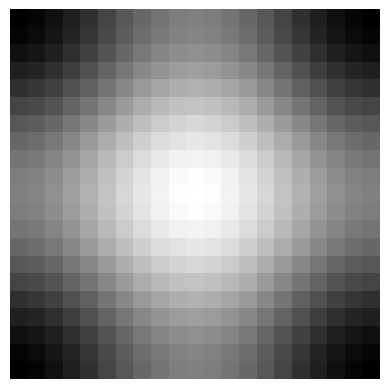

In [5]:
def fourier_transform_filter(filter):
    FilterFRot = np.rot90(np.fft.fftshift(np.rot90(filter, 2)), 2)
    FilterFRot3 = np.dstack((FilterFRot, np.zeros(FilterFRot.shape)))
    FilterFidft = cv2.idft(
        np.float32(FilterFRot3), flags=cv2.DFT_SCALE | cv2.DFT_COMPLEX_OUTPUT
    )
    FilterFI = np.rot90(np.fft.fftshift(FilterFidft[:, :, 0]), 2)

    return FilterFI


transformed_perfect_filter = fourier_transform_filter(perfect_filter)

show_grayscale_image(plt, transformed_perfect_filter)

6.  Aby otrzymać poprawny filtr należy teraz pomnożyć dwuwymiarowe okno ze stworzonym filtrem idealnym w dziedzinie przestrzennej.


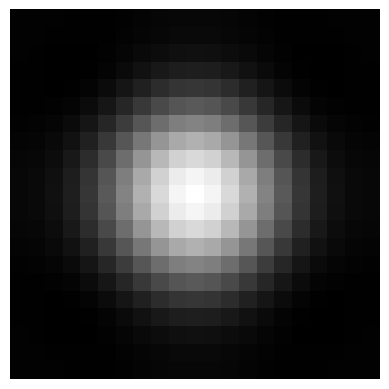

In [6]:
result_filter = transformed_perfect_filter * hanning_filter

show_grayscale_image(plt, result_filter)

7.  Stworzony filtr powinien zostać znowu przeniesiony do dziedziny częstotliwości.
    Należy jednak rozszerzyć go tak, aby miał taki sam rozmiar jak filtrowany obraz.
    Operację tę wykonaj tak samo jak w poprzednim ćwiczeniu (`cv2.copyMakeBorder`).
    Oblicz transformatę Fouriera i wykonaj przesunięcie.
    Następnie oblicz wartość bezwzględną (dzięki temu filtr nie będzie wpływał na fazę).
    Wynikiem jest poprawiony filtr w dziedzinie częstotliwości.


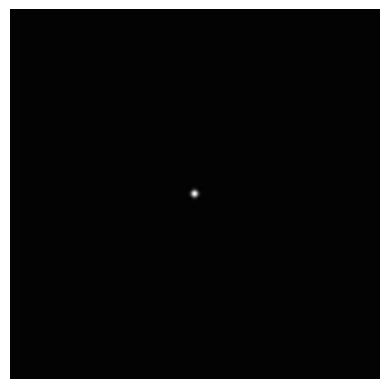

In [7]:
from math import floor, ceil

dy, dx = [a - b for a, b in zip(lena_image.shape, result_filter.shape)]

padded_filter = cv2.copyMakeBorder(
    result_filter,
    left=floor(dx / 2),
    right=ceil(dx / 2),
    top=floor(dy / 2),
    bottom=ceil(dy / 2),
    borderType=cv2.BORDER_CONSTANT,
    value=0,
)

show_grayscale_image(plt, padded_filter)

8.  Przeprowadź filtrację obrazu _lena.bmp_ za pomocą zaprojektowanego filtra.
    Wyświetl filtr, oraz wynik filtracji.
    Do wyświetlenia filtru możesz użyć przestrzeń częstotliwości wygenerowaną w poprzednim zadaniu (_FSpaceRowsM_ i _FSpaceColsM_).


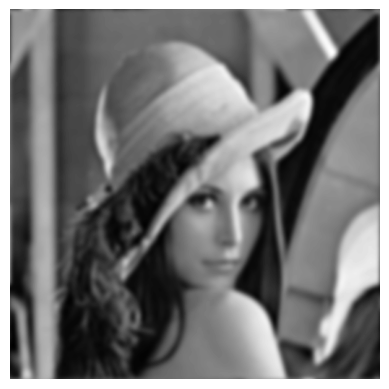

In [8]:
def discrete_fourier_transform(image):
    f_image = cv2.dft(np.float64(image), flags=cv2.DFT_COMPLEX_OUTPUT)
    f_image = np.fft.fftshift(f_image, axes=[0, 1])

    amplitude, phase = f_image[:, :, 0], f_image[:, :, 1]

    return amplitude, phase


def inverse_fourier_transform(amplitude, phase):
    f_image = np.stack([amplitude, phase], axis=2)
    f_image = np.fft.ifftshift(f_image, axes=[0, 1])

    inverted_f_image = cv2.idft(f_image, flags=cv2.DFT_SCALE | cv2.DFT_COMPLEX_OUTPUT)
    original_image = cv2.magnitude(inverted_f_image[:, :, 0], inverted_f_image[:, :, 1])

    return np.round(original_image).astype(np.uint8)


def fourier_with_filter(image, filter):
    filter_amp, filter_phase = discrete_fourier_transform(filter)
    final_filter = np.sqrt(np.square(filter_amp) + np.square(filter_phase))

    amplitude, phase = [
        final_filter * result for result in discrete_fourier_transform(image)
    ]
    return inverse_fourier_transform(amplitude, phase)


show_grayscale_image(plt, fourier_with_filter(lena_image, padded_filter))